## Data loading and preparation

In [1]:
#!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import *
import seaborn as sb
import PIL

In [2]:
# from fastai.vision.all import *
# path = Path().parent

In [3]:
brew_types = 'Mold', 'Not Mold'
path = Path('/notebooks/Kombucha/Clean Data/')

In [4]:
#Function to create a dataloader with flexible batch sze and batch transform resizing
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                       #Get image files from wd path
                       get_items=get_image_files, 
                       #30% validation set
                       splitter=RandomSplitter(valid_pct=0.30, seed=42),
                       #Photo folders are target labels
                       get_y=parent_label,
                       #Resize all photos to 460
                       item_tfms=Resize(460),
                       #Batch transforms, shrink photos to smaller size and perform other augmentations
                       batch_tfms=aug_transforms(size=size, min_scale=.65))
    return dblock.dataloaders(path, bs=bs)

In [5]:
def loss_plot(recorder_vals):
    epochs = []
    loss = []
    split = []

    for epoch in range(len(recorder_vals)):
        epochs.append(epoch)
        epochs.append(epoch)
        loss.append(recorder_vals[epoch][0])
        split.append('Train')
        loss.append(recorder_vals[epoch][1])
        split.append('Val')

    loss_vals = pd.DataFrame({'Epoch': epochs,
                      'Loss': loss,
                      'Split': split})

    sb.lineplot(data=loss_vals, x="Epoch", y="Loss", hue="Split")

### Models

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.215140,0.777575,0.694444,0.659984,0.686275,00:02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.092027,0.741389,0.750000,0.717723,0.753501,00:02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.892966,0.745057,0.694444,0.678322,0.714286,00:02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.846180,0.645374,0.694444,0.668765,0.700280,00:02


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.034274,0.625125,0.750000,0.694118,0.669468,00:03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.688146,0.583544,0.777778,0.740741,0.773109,00:03
1,0.815118,0.608069,0.819444,0.783445,0.816527,00:03
2,0.742416,0.551875,0.819444,0.780909,0.788515,00:03
3,0.712792,0.541012,0.819444,0.781250,0.802521,00:03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.678619,0.415997,0.875000,0.851923,0.841737,00:03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.685436,0.419813,0.888889,0.865546,0.865546,00:04
1,0.612288,0.424027,0.861111,0.828749,0.845938,00:04
2,0.642009,0.421860,0.888889,0.865546,0.865546,00:04
3,0.646302,0.419809,0.888889,0.865546,0.865546,00:04
4,0.663286,0.405344,0.888889,0.865546,0.865546,00:04
5,0.671797,0.405933,0.888889,0.860692,0.879552,00:04
6,0.689085,0.402292,0.875000,0.846364,0.855742,00:04
7,0.669236,0.396760,0.888889,0.860692,0.879552,00:04
8,0.635539,0.395732,0.888889,0.858723,0.893557,00:04
9,0.631764,0.406272,0.888889,0.860692,0.879552,00:04


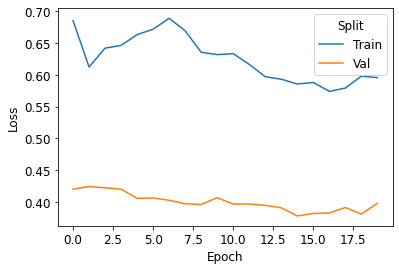

In [6]:
dls = get_dls(16, 128)
#Use pretrained resnet model
learn_labels_tl = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy())

learn_labels_tl.metrics=[accuracy,
               Precision(average='macro'),
               Recall(average='macro')]

learn_labels_tl.fit_one_cycle(1, 10e-4)
learn_labels_tl.fit_one_cycle(1, 10e-4)
learn_labels_tl.fit_one_cycle(1, 10e-4)
learn_labels_tl.fit_one_cycle(1, 10e-4)
#Increase image resize and decrease learning rate
learn_labels_tl.dls = get_dls(16, 256)
learn_labels_tl.fine_tune(4, 7e-4)
#Transfer learn on last few epochs
learn_labels_tl.unfreeze()  
learn_labels_tl.dls = get_dls(16, 350)
learn_labels_tl.fine_tune(20, 1e-4)
learn_labels_tl.freeze() 

loss_labels_tl = learn_labels_tl.recorder.values
loss_plot(loss_labels_tl)

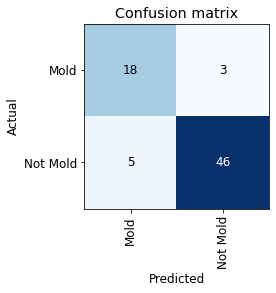

In [7]:
interp = ClassificationInterpretation.from_learner(learn_labels_tl)
interp.plot_confusion_matrix()

In [8]:
#learn_labels_tl.export('/notebooks/Kombucha/KombuchaVision_3.17.21.pkl')

In [9]:
path = Path('/notebooks/Kombucha/')
learn_inf = load_learner(path/'KombuchaVision_3.17.21.pkl')

In [10]:
learn_inf.summary

<bound method Learner.summary of <fastai.learner.Learner object at 0x7fa8787b7d60>>

In [11]:
pred = learn_inf.predict('/notebooks/Kombucha/IMG_1920.jpg')
pred

('Not Mold', tensor(1), tensor([0.0154, 0.9846]))